### Importing needed libraries.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
# To see all the columns.
pd.set_option("display.max_columns",None)

### 1-Understanding the dataset
#### Invoice: Transaction code. If its starts with C or A, it means transaction is refund.
#### StockCode: Product's unique code.
#### Description: Product's name.
#### Quantity: Number of products.
#### InvoiceDate: Transaction date.
#### Price: Transaction price.
#### Customer ID: Customers unique code.
#### Country: Name of the country.

### Few notes before we start. 
##### This dataset has outliers. But they are also our R-F-M scores. That's why we are not touch them.

In [2]:
data=pd.read_excel(r"online_retail_II.xlsx",sheet_name="Year 2010-2011")
df=data.copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


#### There are negative values in the Quantity and Price variable. We should drop them.

In [5]:
df.describe(exclude=["float64","int64"],datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
Invoice,541910,25900,573585,1114,NaT,NaT,NaT,NaT,NaT,NaT
StockCode,541910,4070,85123A,2313,NaT,NaT,NaT,NaT,NaT,NaT
Description,540456,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT,NaT,NaT,NaT,NaT
InvoiceDate,541910,NaN,NaN,NaN,2011-07-04 13:35:22.342073344,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00
Country,541910,38,United Kingdom,495478,NaT,NaT,NaT,NaT,NaT,NaT


#### In the data set, there are values in the Invoice variable with C and A at the beginning. These values mean a refund. That's why, they should be dropped. There are also null values in the Customer ID variable. We can't do RFM analysis of the customer we don't know. Therefore, the null values in this variable should also be dropped.

### 2-Preparing the dataset

In [6]:
df=df[~(df["Quantity"]<=0)]
df=df[~(df["Price"]<=0)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,530105.0,10.542019,155.523977,1.000,1.00,3.00,10.00,80995.00
Price,530105.0,3.907652,35.915652,0.001,1.25,2.08,4.13,13541.33
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


In [7]:
df=df[~((df["Invoice"].str.contains("C",na=False)) | (df["Invoice"].str.contains("A",na=False)))]

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

#### It's time to implement the decisions we made in the previous section.
##### 1-Dropping negative values from the Quantity and Price variables.
##### 2-Dropped returns from the Invoice variable.
##### 3-Dropped all nan values from the Customer ID and Description variables.

#### We will make a quantity * price to find the total amount of money that customers have paid.

In [10]:
df["TotalPrice"]=df["Quantity"]*df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### 3-Calculations of RFM Metrics
#### RFM stands for --> Recency - Frequency - Monetary

#### The dates are old, so we set a day as today based on the highest date in the data.

In [11]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [12]:
today_date=dt.datetime(2011,12,11)

#### Here we have found out when each customer last made a transaction (Recency) , how many transactions they made (Frequency) and the total monetary value of their transactions (Monetary).

In [13]:
rfm=df.groupby("Customer ID").agg({"InvoiceDate":lambda InvoiceDate:(today_date-InvoiceDate.max()).days
                               ,"Invoice":lambda Invoice:Invoice.nunique()
                               ,"TotalPrice":lambda TotalPrice:TotalPrice.sum()})
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [14]:
rfm.columns=["recency","frequency","monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,93.059474,100.012264,1.00,18.000,51.000,142.75,374.00
frequency,4338.0,4.272015,7.697998,1.00,1.000,2.000,5.00,209.00
monetary,4338.0,2054.270609,8989.229895,3.75,307.415,674.485,1661.74,280206.02


### 4-Calculations of RFM Scores

#### Values that are small for the Recency variable receive a higher score. The fact that the last transaction made by the customer is in the near future is what we want.
#### However, frequency and monetary values do not fit with this. Their larger values get higher scores.

In [15]:
rfm["recency_score"]=pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])
#I used rank(method="first") cause its not worked by normal way. I founded it from stackoverflow.com :)
rfm["frequency_score"]=pd.qcut(rfm["frequency"].rank(method="first"),5,labels=[1,2,3,4,5])
rfm["monetary_score"]=pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
Customer ID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,3,7,4310.00,5,5,5
12348.0,76,4,1797.24,2,4,4
12349.0,19,1,1757.55,4,1,4
12350.0,311,1,334.40,1,1,2
...,...,...,...,...,...,...
18280.0,278,1,180.60,1,2,1
18281.0,181,1,80.82,1,2,1
18282.0,8,2,178.05,5,3,1


In [16]:
rfm["RFM_Score"]=rfm["recency_score"].astype(str)+rfm["frequency_score"].astype(str)
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score
Customer ID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,311,1,334.40,1,1,2,11
...,...,...,...,...,...,...,...
18280.0,278,1,180.60,1,2,1,12
18281.0,181,1,80.82,1,2,1,12
18282.0,8,2,178.05,5,3,1,53


### 5-Creation and Analysis of RFM Segments

##### Here our segments:
#### 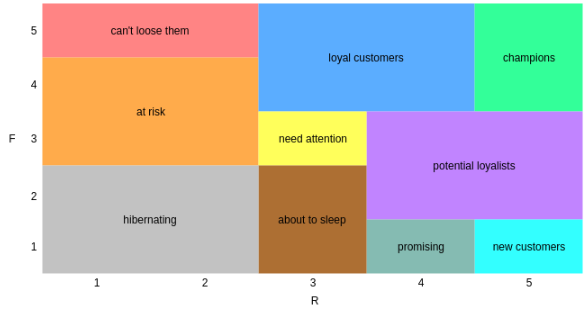

In [17]:
segmentation_map={
    r"[1-2][1-2]":"hibernating",
    r"[1-2][3-4]":"at_risk",
    r"[1-2]5":"cant_loose",
    r"3[1-2]":"about_to_sleep",
    r"33":"need_attention",
    r"[3-4][4-5]":"loyal_customers",
    r"41":"promising",
    r"51":"new_customers",
    r"[4-5][2-3]":"potential_loyalists",
    r"5[4-5]":"champions",
}
rfm["segment"]=rfm["RFM_Score"].replace(segmentation_map,regex=True)
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,segment
Customer ID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1797.24,2,4,4,24,at_risk
12349.0,19,1,1757.55,4,1,4,41,promising
12350.0,311,1,334.40,1,1,2,11,hibernating
...,...,...,...,...,...,...,...,...
18280.0,278,1,180.60,1,2,1,12,hibernating
18281.0,181,1,80.82,1,2,1,12,hibernating
18282.0,8,2,178.05,5,3,1,53,potential_loyalists


### Attention! The values here are not our scores. It is the data itself.

In [18]:
rfm[["segment","recency","frequency","monetary"]].groupby("segment").agg(["mean","count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep        53.312500   352   1.161932   352   471.994375   352
at_risk              153.785835   593   2.876897   593  1084.535297   593
cant_loose           132.968254    63   8.380952    63  2796.155873    63
champions              6.361769   633  12.413902   633  6857.963918   633
hibernating          217.605042  1071   1.101774  1071   488.643307  1071
loyal_customers       33.608059   819   6.479853   819  2864.247791   819
need_attention        52.427807   187   2.326203   187   897.627861   187
new_customers          7.428571    42   1.000000    42   388.212857    42
potential_loyalists   17.398760   484   2.010331   484  1041.222004   484
promising             23.510638    94   1.000000    94   294.007979    94

### The Python part of our RFM analysis ends here. From here on, the process is translated into a function. If you are interested, you can review it.

In [20]:
def create_rfm(dataframe,reset_index=False,csv=False):
    
    # PREPARING THE DATASET
    dataframe = dataframe[~(dataframe["Quantity"]<=0)]
    dataframe = dataframe[~(dataframe["Price"]<=0)]
    dataframe[(dataframe["Invoice"].str.contains("C",na=False)) | (dataframe["Invoice"].str.contains("A",na=False))]
    dataframe = dataframe[~(dataframe["Invoice"].str.contains("A", na=False))]
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    dataframe.dropna(inplace=True)
    # CALCULATIONS OF RFM METRICS
    today_date = dt.datetime(2011,12,11)
    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})
    rfm.columns = ['recency', 'frequency', "monetary"]
    rfm = rfm[(rfm['monetary'] > 0)]

    # CALCULATIONS OF RFM SCORES
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
    rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                        rfm['frequency_score'].astype(str))


    # CREATION OF RFM SEGMENTS
    segmentation_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    rfm['segment'] = rfm['RFM_SCORE'].replace(segmentation_map, regex=True)
    rfm = rfm[["recency", "frequency", "monetary", "segment"]]
    rfm.index = rfm.index.astype(int)
    if reset_index==True:
        rfm=rfm.reset_index()
    if csv==True:
        rfm.to_csv("rfm.csv")
    
    return rfm

### It works if the data set is run and given directly to the function without any other steps.

In [22]:
rfm_new=create_rfm(data,reset_index=False,csv=False)
rfm_new

,recency,frequency,monetary,segment
Customer ID,,,,
12346,326,1,77183.60,hibernating
12347,3,7,4310.00,champions
12348,76,4,1797.24,at_risk
12349,19,1,1757.55,promising
12350,311,1,334.40,hibernating
...,...,...,...,...
18280,278,1,180.60,hibernating
18281,181,1,80.82,hibernating
18282,8,2,178.05,potential_loyalists


### If it is assumed that the RFM analysis is performed month by month or over a specified period, thanks to this function, changes in the status of customized customers can be observed according to the previous RFM analysis values. For example, in the ninth month, RFM analysis is performed and a plan is made according to the customers in the at_risk group. The results of the RFM analysis in the tenth month can be examined to see the changes as a result of this plan.